In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def filter_submissions(df):
    filt = df.groupby(level=0).size() > 1
    return df[filt[df.index.get_level_values(level=0)].values]

# Classifier columns to study
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


beatles = pd.read_hdf(Path.cwd() / 'datasets' / 'beatles.h5')
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

C:\Users\Chris\Miniconda3\envs\thesis2\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
toplot = pd.DataFrame()


beatles_all = beatles.progress_apply(filter_submissions)
beatles_all_variance = beatles_all[cols].progress_apply(get_variance)
beatles_all_variance['Data source'] = "Beatles songs"
toplot = toplot.append(beatles_all_variance)

acousticbrainz_all = acousticbrainz.progress_apply(filter_submissions)
acousticbrainz_all_variance = acousticbrainz_all[cols].progress_apply(get_variance)
acousticbrainz_all_variance['Data source'] = "Full dataset"
toplot = toplot.append(acousticbrainz_all_variance)

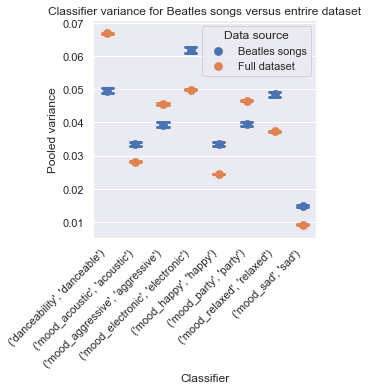

In [3]:
toplot = toplot.melt(id_vars = ['Data source'])
plt.figure(figsize=(4, 4))
ax = sns.pointplot(data=toplot, x='variable', y='value', hue="Data source", errwidth=3, capsize=.4, join=False, ci=95)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for Beatles songs versus entrire dataset")
plt.xlabel("Classifier")
plt.ylabel("Pooled variance")
plt.show()

In [4]:
beatles_bitrate = beatles.groupby(['bit_rate']).progress_apply(filter_submissions)
beatles_bitrate_variance = beatles_bitrate[cols].groupby(level=[0,1]).progress_apply(get_variance)

,0
128000,479
192000,396
256000,161
320000,181
448000,4042


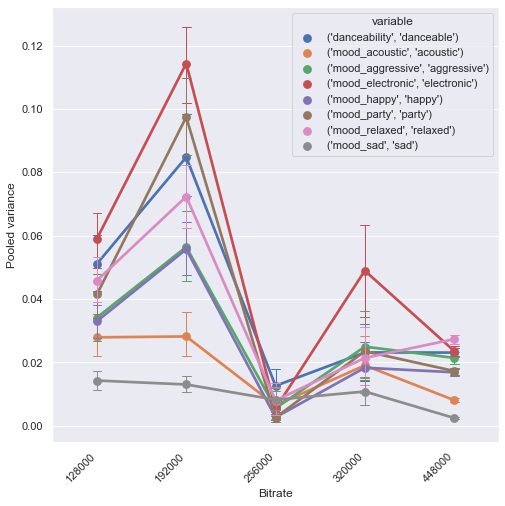

In [17]:
bitrates = [128000, 192000, 256000, 320000, 0]
idx = [128000, 192000, 256000, 320000, 448000]
toplot = pd.DataFrame()
counts = []

for rate in bitrates:
    toadd = beatles_bitrate_variance.loc[rate]
    toadd['bitrate'] = rate
    toplot = toplot.append(toadd)
    counts.append(len(toadd))

counts = pd.DataFrame(counts)
counts.index = idx
display(counts)

toplot['bitrate'] = toplot['bitrate'].replace(to_replace=0, value=448000)
toplot = toplot.melt(id_vars=['bitrate'])


plt.figure(figsize=(8,8))
ax = sns.pointplot(data=toplot, x='bitrate', y='value', hue="variable", errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
#plt.title(f"Classifier variance for Beatles songs across bitrates\nNo downsampling used\n448000 indicates lossless")
plt.xlabel("Bitrate")
plt.ylabel("Pooled variance")
plt.show()

In [13]:
print(counts.to_latex())

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
128000 &   479 \\
192000 &   396 \\
256000 &   161 \\
320000 &   181 \\
448000 &  4042 \\
\bottomrule
\end{tabular}



# Classifier distributions

In [ ]:
# List of columns to inspect, binary 'mood' features. Positive class is always chosen
toSelect = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'),
       ('mood_aggressive', 'aggressive'), ('mood_electronic', 'electronic'),
       ('mood_happy', 'happy'), ('mood_party', 'party'),
       ('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]
cols = [beatles[x] for x in toSelect]
labels = [x[0] for x in toSelect]

fig = plt.figure(figsize=(8,8))
plt.xlabel('Bin range')
plt.ylabel('Bin count')

for i in range(0, len(cols)):
    y,binEdges = np.histogram(cols[i],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, label=labels[i])

plt.legend()
plt.show()

# Study of 'Yesterday' by The Beatles
'Yesterday' by The Beatles is quite objectively not a happy song, however it would be interesting to see how the mood probabilities are distributed over all different submissions. We use the dataset 'yesterday.h5' which include all submissions with artist='The Beatles' and title='Yesterday'

In [ ]:
yesterday = pd.read_hdf(Path.cwd() / 'datasets' / 'yesterday.h5')

How are the label probabilities for (mood_sad, sad) and (mood_happy, not_happy) distributed?

In [ ]:
sns.distplot(yesterday[('mood_sad', 'sad')])

In [ ]:
sns.distplot(yesterday[('mood_happy', 'not_happy')])

Which are submissions are most 'wrong'?

In [ ]:
idx_wrongsad = yesterday[('mood_sad', 'sad')].idxmin()
wrongsad = yesterday.loc[idx_wrongsad]

idx_correctsad = yesterday[('mood_sad', 'sad')].idxmax()
correctsad = yesterday.loc[idx_correctsad]

print(f"The lowest probability of the song being sad was {wrongsad[('mood_sad', 'sad')]}. \n This submission used codec: {wrongsad['codec']} with bitrate {wrongsad['bit_rate']} \n This submission used version {wrongsad['essentia_low']}, {wrongsad['essentia_git_sha_low']}, {wrongsad['essentia_build_sha_low']}")
print()
print(f"The highest probability of the song being sad was {correctsad[('mood_sad', 'sad')]}. \n This submission used codec: {correctsad['codec']} with bitrate {correctsad['bit_rate']} \n This submission used version {correctsad['essentia_low']}, {correctsad['essentia_git_sha_low']}, {correctsad['essentia_build_sha_low']}")
print()
print()
      
idx_wronghappy = yesterday[('mood_happy', 'happy')].idxmax()
wronghappy = yesterday.loc[idx_wronghappy]
    
idx_correcthappy = yesterday[('mood_happy', 'happy')].idxmin()
correcthappy = yesterday.loc[idx_correcthappy]

print(f"The highest probability of the song being happy was {wronghappy[('mood_happy', 'happy')]}. \n This submission used codec: {wronghappy['codec']} with bitrate {wronghappy['bit_rate']} \n This submission used version {wronghappy['essentia_low']}, {wronghappy['essentia_git_sha_low']}, {wronghappy['essentia_build_sha_low']}")
print()
print(f"The lowest probability of the song being happy was {correcthappy[('mood_happy', 'happy')]}. \n This submission used codec: {correcthappy['codec']} with bitrate {correcthappy['bit_rate']} \n This submission used version {correcthappy['essentia_low']}, {correcthappy['essentia_git_sha_low']}, {correcthappy['essentia_build_sha_low']}")

### And, if we assume that the 'correct' labels are 'not_happy' and 'sad', what is the accuracy of the mood classification?

In [ ]:
# First, get the labels
yesterday['label_sad'] = yesterday[('mood_sad', 'sad')] > 0.5
yesterday['label_not_happy'] = yesterday[('mood_happy', 'not_happy')] > 0.5

tocheck = yesterday[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label_sad', 'label_not_happy']]


# Now we can calulate the accuracy against the ground truth :D
print(f"Accuracy across all submissions: {100 * len(tocheck[(tocheck['label_sad']) & (tocheck['label_not_happy'])]) / len(tocheck)}%")

In [ ]:
groups = tocheck.groupby('codec')
for k, v in groups:
    total = len(v)
    correct = len(v[(v['label_sad']) & (v['label_not_happy'])])
    print(f"Accuracy for codec {k}: {correct}/{total}, {100 * correct/total}%")

In [ ]:
groups = tocheck.groupby('essentia_low')
for k, v in groups:
    total = len(v)
    correct = len(v[(v['label_sad']) & (v['label_not_happy'])])
    print(f"Accuracy for version {k}: {correct}/{total}, {100 * correct/total}%")